# Online DA Calibration: 
## CESM LME prior/LIM, HadCRUT5 observations

In [1]:
import sys
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pickle 

In [2]:
import Online_DA_utils as oda

In [3]:
import importlib
importlib.reload(oda)

<module 'Online_DA_utils' from '/home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/recon_scripts/Online_DA_utils.py'>

In [4]:
t=0

### Load L: 

In [5]:
#LIM = oda.load_L('CESM_LME_nh')
LIM = oda.load_L('cesm_lme_Amon')
LIMd = LIM['LIMd']
LIMd.keys()

Loading: /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/master/LIMcast_cesm_lme_Amon_ntrain_850_1650_cesm_lme_Amon_validy_1651_1850_tas50L0.1_psl50L0.1_zg50L0.1_tos50L0.1_sit50L40_sic50L40_20211202_sqrtWt.pkl


dict_keys(['vec', 'veci', 'val', 'lam_L', 'C_0', 'C_1', 'Gt', 'lam_L_adj', 'npos_eigenvalues', 'E3', 'W_all', 'standard_factor', 'E3_all', 'E_sic', 'var_dict', 'P_train', 'exp_setup', 'frac_neg_eigenvals'])

In [6]:
# Xb_initial = LIM['forecast']['P_train_valid'][:,2399]
# Xb_initial.shape

# Pb_initial = oda.covariance(Xb_initial[:,np.newaxis],Xb_initial[:,np.newaxis].T)
# Pb_initial.shape

In [7]:
Projector_tas = LIMd['E3']['tas']

### Load HadCRUT5 observations: 

In [8]:
HadCRUT_tas, HadCRUT_lat, HadCRUT_lon, HadCRUT_time = oda.load_HadCRUT5()
HadCRUT_lon[:36] = HadCRUT_lon[:36] +360
HadCRUT_lon

array([182.5, 187.5, 192.5, 197.5, 202.5, 207.5, 212.5, 217.5, 222.5,
       227.5, 232.5, 237.5, 242.5, 247.5, 252.5, 257.5, 262.5, 267.5,
       272.5, 277.5, 282.5, 287.5, 292.5, 297.5, 302.5, 307.5, 312.5,
       317.5, 322.5, 327.5, 332.5, 337.5, 342.5, 347.5, 352.5, 357.5,
         2.5,   7.5,  12.5,  17.5,  22.5,  27.5,  32.5,  37.5,  42.5,
        47.5,  52.5,  57.5,  62.5,  67.5,  72.5,  77.5,  82.5,  87.5,
        92.5,  97.5, 102.5, 107.5, 112.5, 117.5, 122.5, 127.5, 132.5,
       137.5, 142.5, 147.5, 152.5, 157.5, 162.5, 167.5, 172.5, 177.5])

In [9]:
HadCRUT_tas_nh = HadCRUT_tas[:,18:,:]
HadCRUT_lat_nh = HadCRUT_lat[18:]

In [10]:
nobs_had = np.isfinite(HadCRUT_tas_nh[0,:,:]).sum()
nobs_had

271

In [11]:
HadCRUT_unc_tas, HadCRUT_unc_lat, HadCRUT_unc_lon, HadCRUT_unc_time = oda.load_HadCRUT5_uncertainty()
HadCRUT_unc_tas_nh = HadCRUT_unc_tas[:,18:,:]
HadCRUT_unc_lat_nh = HadCRUT_unc_lat[18:]

In [12]:
HadCRUT_lat_2d = HadCRUT_lat_nh[:,np.newaxis]*np.ones((HadCRUT_lat_nh.shape[0],HadCRUT_lon.shape[0]))
HadCRUT_lon_2d = np.ones((HadCRUT_lat_nh.shape[0],HadCRUT_lon.shape[0]))*HadCRUT_lon[np.newaxis,:]

In [13]:
HadCRUT_obs_1d = HadCRUT_tas_nh[t,np.isfinite(HadCRUT_tas_nh[t,:,:])]
HadCRUT_obs_unc_1d = HadCRUT_unc_tas_nh[t,np.isfinite(HadCRUT_unc_tas_nh[t,:,:])]
HadCRUT_obs_lat = HadCRUT_lat_2d[np.isfinite(HadCRUT_tas_nh[t,:,:])]
HadCRUT_obs_lon = HadCRUT_lon_2d[np.isfinite(HadCRUT_tas_nh[t,:,:])]

## Load initial conditions in lat/lon space: 

In [14]:
priorpath = '/home/disk/chaos/mkb22/Documents/SeaIceData/LME/LIMs/'
#priorname = 'Prior_state_tas_tos_psl_zg500_sit_sic_latcut0_1_CESM_LME_Amon_time_1650.pkl.npz'
priorname = 'Prior_state_tas_tos_psl_zg500_latcut0_1_sit_sic_latcut40_CESM_LME_Amon_time_1650_1850.pkl.npz'

Xb_allvars = np.load(priorpath+priorname)
Xb_allvars_initial = Xb_allvars['Xb_allvars'][:,-12]

In [15]:
Xb_initial = Xb_allvars_initial

In [16]:
priorcov_name2 = 'Prior_covariance_tas_tos_psl_zg500_latcut0_1_sit_sic_latcut40_CESM_LME_Amon_time_1650_1850.pkl.npz'
priorcov_name = 'Prior_covariance_tas_tos_psl_zg500_latcut0_1_sit_sic_latcut40_CESM_LME_Amon_time_1850_01.pkl.npz'
Pb_data = np.load(priorpath+priorcov_name)
Pb_initial = Pb_data['Pb_initial']

Pb_data2 = np.load(priorpath+priorcov_name2)
Pb_initial2 = Pb_data2['Pb_initial']

In [17]:
Pb_initial3 = oda.covariance_nans(Xb_allvars['Xb_allvars'][:,-12:],
                                  Xb_allvars['Xb_allvars'][:,-12:].T, anomalize=False)

In [18]:
#Pb_initial = np.dot(np.nan_to_num(Xb_allvars_initial)[:,np.newaxis],np.nan_to_num(Xb_allvars_initial)[:,np.newaxis].T)/Xb_allvars_initial.shape[0]
# Pb_initial = oda.covariance_nans(Xb_allvars_initial[:,np.newaxis],Xb_allvars_initial[:,np.newaxis].T, anomalize=False)
# Xb_initial = Xb_allvars_initial

In [19]:
#Pb_initial = oda.covariance_nans(Xb_allvars['Xb_allvars'],Xb_allvars['Xb_allvars'].T, anomalize=False)

In [ ]:
# cesm_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/LME/LIMs/'
# save_filename = 'Prior_covariance_tas_tos_psl_zg500_sit_sic_latcut0_1_CESM_LME_Amon_time_1650_1850.pkl.npz'

# np.savez(cesm_dir+save_filename,Pb_initial=Pb_initial)

### Project covariance into eof space: 

In [158]:
def project_validation_cov(limvars, Pa, LIMd): 
    """
    """
    Ptrunc = {}
    
    for var in limvars:
        print('Working on '+var)
        standard_factor = LIMd['standard_factor'][var]
        E3 = LIMd['E3'][var]
        W = LIMd['W_all'][var]
        Weights = LIMd['exp_setup']['Weight']
        var_inds = LIMd['var_dict'][var]['var_inds']
        X = Pa[var_inds,var_inds]
        
        if Weights is True: 
            if len(W.shape)<2:
                W_new = W[:,np.newaxis]
            else: 
                W_new = W
            eofs_out = E3/standard_factor
            print(eofs_out.shape)

            # projection
            P_var = np.matmul(eofs_out.T,W_new*np.nan_to_num(X))
            Ptrunc_left = P_var/standard_factor
            print(Ptrunc_left.shape)
            
            Ptrunc_right = np.matmul(W_new.T*np.nan_to_num(Ptrunc_left),eofs_out)
            Ptrunc[var] = Ptrunc_right/standard_factor
        else: 
            eofs_out = E3/standard_factor
            # projection
            P_var = np.matmul(eofs_out.T,np.nan_to_num(X))
            Ptrunc_left = P_var/standard_factor
            
            Ptrunc_right = np.matmul(np.nan_to_num(Ptrunc_left),eofs_out)
            Ptrunc[var] = Ptrunc_right/standard_factor 
        
    return Ptrunc

In [ ]:
E3_all[var_dict[var]['var_inds'],int(v*ntrunc):int((v+1)*ntrunc)] = E3[var]

In [159]:
limvars = ['tas','psl','zg','tos','sit','sic']

In [160]:
Pb_trunc = project_validation_cov(limvars, Pb_initial2, LIMd)

Working on tas
(6912, 50)
(50, 6912)
Working on psl
(6912, 50)
(50, 6912)
Working on zg
(6912, 50)
(50, 6912)
Working on tos
(6912, 50)
(50, 6912)
Working on sit
(3888, 50)
(50, 3888)
Working on sic
(3888, 50)
(50, 3888)


In [165]:
for var in limvars:
    print(var)
    Pb_trunc_all = np.concatenate((Pb_trunc[var],Pb_trunc[var]),axis=0)

tas
psl
zg
tos
sit
sic


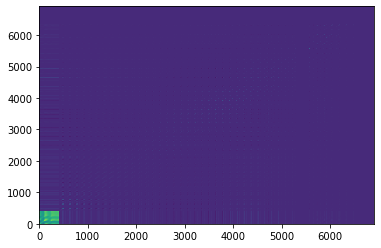

In [9]:
plt.pcolormesh(Pb_initial2[6500:6500+6912,6500:6500+6912])

In [10]:
LIMd['C_0'].shape, LIMd['Gt'].shape

((300, 300), (300, 300))

### Build H: 
H should be a matrix of size (nobs, nlalo) filled with zeros and ones. One one per column at the ob location. 

In [20]:
obsmask_filename = 'Hadcrut_data_mask_CESMLME_grid.pkl'
obsmask_loc_filename = 'Hadcrut_data_mask_with_locations_CESMLME_grid.pkl'
obsmask_loc_filename_nh = 'Hadcrut_data_mask_with_locations_CESMLME_grid_NH.pkl'
obscesm_filename_nh = 'Hadcrut_data_on_CESMLME_grid_NH.pkl'

had_ds = pickle.load(open(obsmask_loc_filename_nh,"rb"))
had_mask_nh = had_ds['hadcrut_closest_CESM_gridpoint']
locations = had_ds['lat_lon_locations']

In [21]:
# had_cesm_ds = pickle.load(open(obscesm_filename_nh,"rb"))
# had_on_refgrid = had_mask['had_on_refgrid']
# had_on_refgrid_2d = np.reshape(had_on_refgrid,(had_on_refgrid.shape[0],ndof))

In [22]:
H_cap, nobs, ndof = oda.build_H_time(had_mask_nh[0,:,:])

In [23]:
H = np.zeros((nobs,Xb_initial.shape[0]))
H[:,0:6912] = H_cap

In [24]:
H.shape

(271, 35424)

In [ ]:
#H_tas = np.matmul(H_cap, Projector_tas)

# H = np.zeros((nobs,Xb_initial.shape[0]))
# H[:,0:50] = H_tas

### Build R: 

In [25]:
R_had = oda.covariance_nans(HadCRUT_obs_unc_1d[:,np.newaxis],HadCRUT_obs_unc_1d[:,np.newaxis].T,anomalize=False)

In [24]:
R_had

array([[0.00126731, 0.00182717, 0.00210172, ..., 0.00250945, 0.00156848,
        0.00119908],
       [0.00182717, 0.00263436, 0.0030302 , ..., 0.00361805, 0.00226139,
        0.0017288 ],
       [0.00210172, 0.0030302 , 0.00348551, ..., 0.0041617 , 0.00260118,
        0.00198856],
       ...,
       [0.00250945, 0.00361805, 0.0041617 , ..., 0.00496907, 0.00310581,
        0.00237434],
       [0.00156848, 0.00226139, 0.00260118, ..., 0.00310581, 0.00194122,
        0.00148403],
       [0.00119908, 0.0017288 , 0.00198856, ..., 0.00237434, 0.00148403,
        0.00113452]])

(6912, 50)

In [52]:
# constant R:
R_test = np.ones((271))*0.4

R_test_cov = np.dot(R_test[:,np.newaxis],R_test[:,np.newaxis].T)

In [183]:
ref_arg_lon = [int(i) for i in locations[0]['reference_arg_lon']]
ref_arg_lat = [int(i) for i in locations[0]['reference_arg_lat']]

In [175]:
cesmdir = '/home/disk/chaos/mkb22/Documents/SeaIceData/LME/LIMs/'
filename = 'tas_sfc_Amon_CESM_LMEallforc_001_085001-200512.nc'
data_cesm_lme = xr.open_dataset(cesmdir+filename)
cesm_lat = data_cesm_lme.lat.values
cesm_lat_nh = cesm_lat[48:]
cesm_lon = data_cesm_lme.lon.values

In [204]:
diff.min(), diff.max()

(-13.892415785576041, 6.763158033010416)

Text(0.5, 1.0, 'Difference: (y - Hx$_b$)')

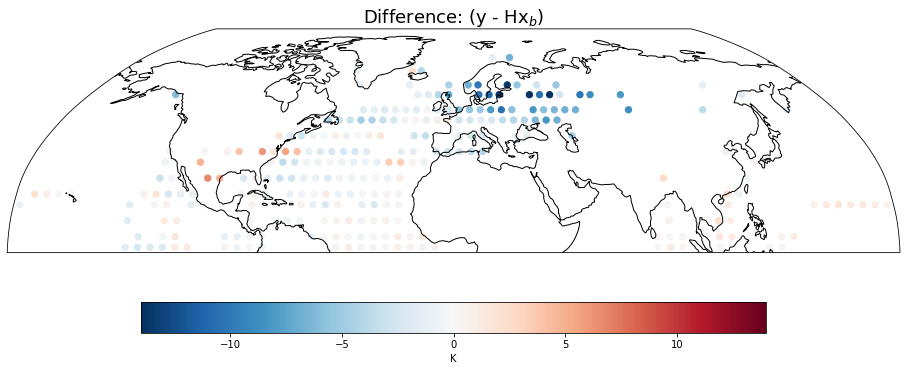

In [217]:
fig = plt.figure(1, figsize=(16, 6))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines()

#hadcrut_ds.tas_mean.isel(time=0).plot.pcolormesh('longitude','latitude',ax=axs,transform=ccrs.PlateCarree(),vmax=10)

# plt.scatter(x=lon,y=lat,s=H,transform=ccrs.PlateCarree())
axs.pcolormesh(cesm_lon,cesm_lat_nh,np.zeros((cesm_lat_nh.shape[0],cesm_lon.shape[0])),
               cmap='binary',transform=ccrs.PlateCarree(),vmin=0)

cb = axs.scatter(cesm_lon[ref_arg_lon],cesm_lat_nh[ref_arg_lat],
            s=40,c=diff,cmap='RdBu_r',transform=ccrs.PlateCarree(),vmin=-14,vmax=14)

plt.colorbar(cb, orientation='horizontal', shrink=0.7, label='K')
plt.title('Difference: (y - Hx$_b$)', fontsize=18)

In [241]:
(np.diagonal(diffcov)).min(), (np.diagonal(diffcov)).max()

(4.580553000162384e-07, 0.7121742301082007)

Text(0.5, 1.0, 'Cov(y - Hx$_b$)')

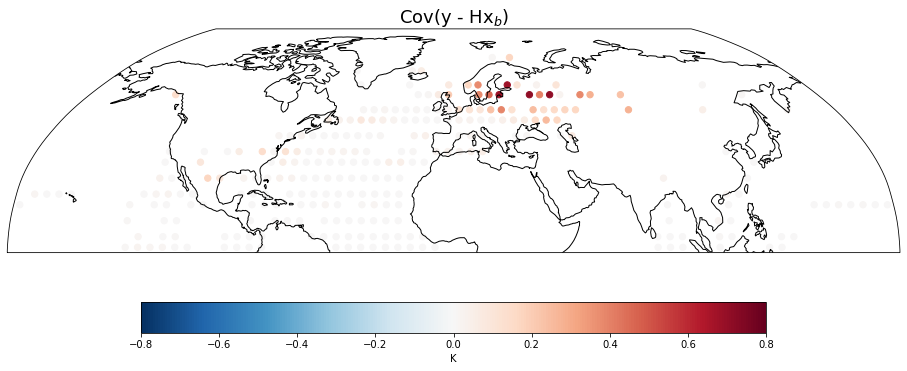

In [247]:
fig = plt.figure(1, figsize=(16, 6))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines()

#hadcrut_ds.tas_mean.isel(time=0).plot.pcolormesh('longitude','latitude',ax=axs,transform=ccrs.PlateCarree(),vmax=10)

# plt.scatter(x=lon,y=lat,s=H,transform=ccrs.PlateCarree())
axs.pcolormesh(cesm_lon,cesm_lat_nh,np.zeros((cesm_lat_nh.shape[0],cesm_lon.shape[0])),
               cmap='binary',transform=ccrs.PlateCarree(),vmin=0)

cb = axs.scatter(cesm_lon[ref_arg_lon],cesm_lat_nh[ref_arg_lat],
            s=40,c=np.diagonal(diffcov),cmap='RdBu_r',transform=ccrs.PlateCarree(),vmin=-0.8,vmax=0.8)

plt.colorbar(cb, orientation='horizontal', shrink=0.7, label='K')
plt.title('Cov(y - Hx$_b$)', fontsize=18)

In [249]:
(np.diagonal(K_den)).max(), (np.diagonal(K_den)).min()

(0.018827645350290186, 7.022342264961643e-05)

In [282]:
(K_den*K_den).max()

0.00038476180130680445

In [338]:
K_den = (np.matmul(HPb,H.T)*100+(R_had))*10

In [324]:
np.diagonal(K_den).max(), R_had.max()

(0.2358704569504384, 0.018826261548199785)

Text(0.5, 1.0, '[HBH$^T$ + R])')

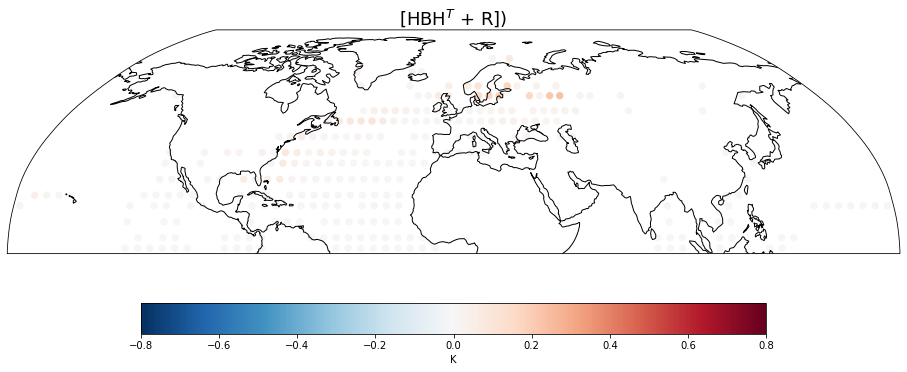

In [325]:
fig = plt.figure(1, figsize=(16, 6))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines()

#hadcrut_ds.tas_mean.isel(time=0).plot.pcolormesh('longitude','latitude',ax=axs,transform=ccrs.PlateCarree(),vmax=10)

# plt.scatter(x=lon,y=lat,s=H,transform=ccrs.PlateCarree())
axs.pcolormesh(cesm_lon,cesm_lat_nh,np.zeros((cesm_lat_nh.shape[0],cesm_lon.shape[0])),
               cmap='binary',transform=ccrs.PlateCarree(),vmin=0)

cb = axs.scatter(cesm_lon[ref_arg_lon],cesm_lat_nh[ref_arg_lat],
            s=40,c=np.diagonal(K_den),cmap='RdBu_r',transform=ccrs.PlateCarree(),vmin=-0.8, vmax=0.8)

plt.colorbar(cb, orientation='horizontal', shrink=0.7, label='K')
plt.title('[HBH$^T$ + R])', fontsize=18)

Text(0.5, 1.0, '[R]')

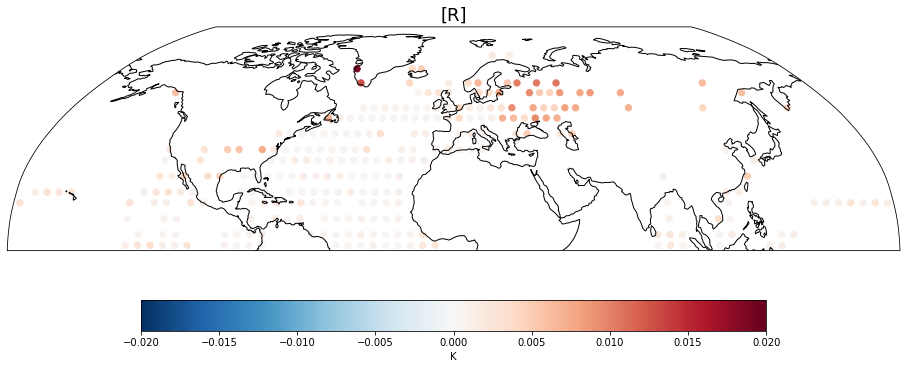

In [311]:
fig = plt.figure(1, figsize=(16, 6))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines()

#hadcrut_ds.tas_mean.isel(time=0).plot.pcolormesh('longitude','latitude',ax=axs,transform=ccrs.PlateCarree(),vmax=10)

# plt.scatter(x=lon,y=lat,s=H,transform=ccrs.PlateCarree())
axs.pcolormesh(cesm_lon,cesm_lat_nh,np.zeros((cesm_lat_nh.shape[0],cesm_lon.shape[0])),
               cmap='binary',transform=ccrs.PlateCarree(),vmin=0)

cb = axs.scatter(cesm_lon[ref_arg_lon],cesm_lat_nh[ref_arg_lat],
            s=40,c=np.diagonal(R_had),cmap='RdBu_r',transform=ccrs.PlateCarree(),vmin=-0.02, vmax=0.02)

plt.colorbar(cb, orientation='horizontal', shrink=0.7, label='K')
plt.title('[R]', fontsize=18)

In [308]:
np.diagonal(np.matmul(HPb,H.T)*100).min()

1.0517428120340709e-07

Text(0.5, 1.0, '[HBH$^T$])')

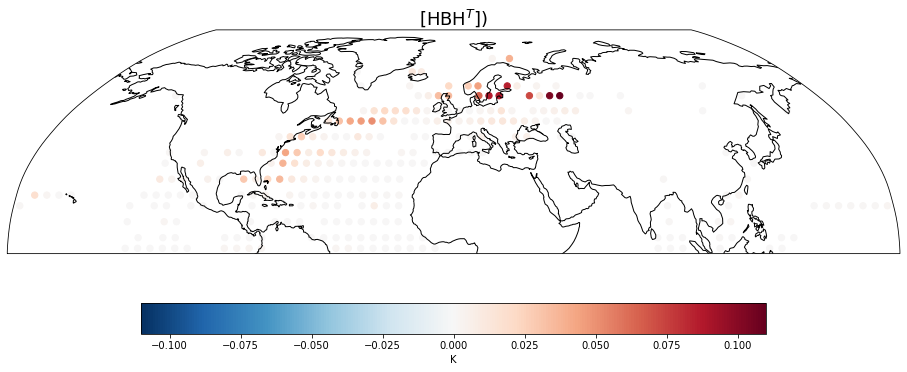

In [310]:
fig = plt.figure(1, figsize=(16, 6))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines()

#hadcrut_ds.tas_mean.isel(time=0).plot.pcolormesh('longitude','latitude',ax=axs,transform=ccrs.PlateCarree(),vmax=10)

# plt.scatter(x=lon,y=lat,s=H,transform=ccrs.PlateCarree())
axs.pcolormesh(cesm_lon,cesm_lat_nh,np.zeros((cesm_lat_nh.shape[0],cesm_lon.shape[0])),
               cmap='binary',transform=ccrs.PlateCarree(),vmin=0)

cb = axs.scatter(cesm_lon[ref_arg_lon],cesm_lat_nh[ref_arg_lat],
                 s=40,c=np.diagonal(np.matmul(HPb,H.T)*100),cmap='RdBu_r',transform=ccrs.PlateCarree(),
                 vmin=-0.11, vmax=0.11)

plt.colorbar(cb, orientation='horizontal', shrink=0.7, label='K')
plt.title('[HBH$^T$]', fontsize=18)

In [251]:
40*(np.diagonal(K_den)).max()

0.7531058140116075

Text(0.5, 1.0, 'Ratio: Cov(y - Hx$_b$)/[HBH$^T$ + R])')

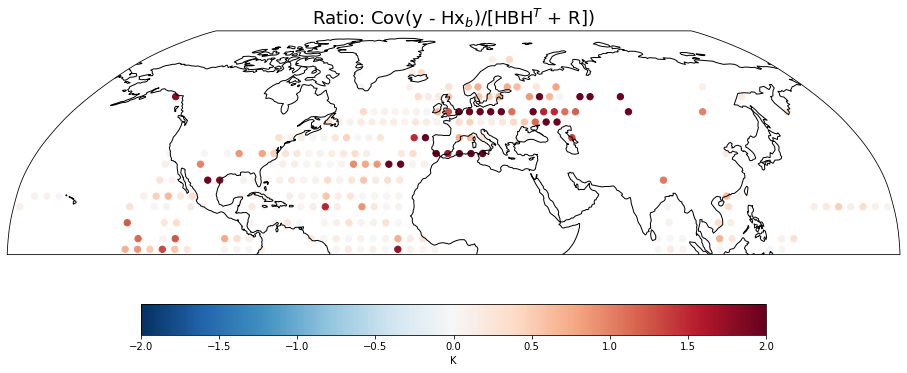

In [339]:
fig = plt.figure(1, figsize=(16, 6))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines()

rt = np.diagonal(diffcov)/(np.diagonal(K_den))

axs.pcolormesh(cesm_lon,cesm_lat_nh,np.zeros((cesm_lat_nh.shape[0],cesm_lon.shape[0])),
               cmap='binary',transform=ccrs.PlateCarree(),vmin=0)

cb = axs.scatter(cesm_lon[ref_arg_lon],cesm_lat_nh[ref_arg_lat],
            s=40,c=rt,cmap='RdBu_r',transform=ccrs.PlateCarree(),vmin=-2, vmax=2)

plt.colorbar(cb, orientation='horizontal', shrink=0.7, label='K')
plt.title('Ratio: Cov(y - Hx$_b$)/[HBH$^T$ + R])', fontsize=18)

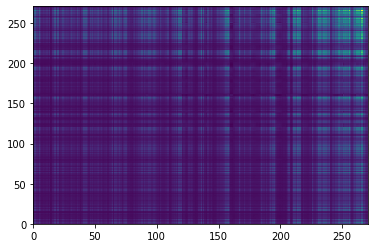

In [224]:
plt.pcolormesh(K_den)

## Test Calibration: 

In [11]:
Pb_initial5 = LIMd['C_0']

In [ ]:
Pb_initial2

In [12]:
K_num2 = np.matmul(Pb_initial3,H.T)

NameError: name 'H' is not defined

In [62]:
HPb = np.matmul(H,Pb_initial)
K_den = np.matmul(HPb,H.T)+R_had

In [63]:
K_den_inv = np.linalg.inv(K_den)

In [64]:
diff = HadCRUT_obs_1d - np.matmul(H,np.nan_to_num(Xb_initial))

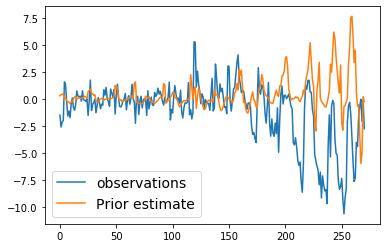

In [65]:
plt.plot(HadCRUT_obs_1d, label='observations')
plt.plot(np.matmul(H,np.nan_to_num(Xb_initial)), label='Prior estimate')
#plt.xlim(0,50)
plt.legend(loc='lower left',fontsize=14)

In [66]:
diffcov = np.dot(diff[:,np.newaxis],diff[:,np.newaxis].T)/diff.shape[0]

Text(0, 0.5, '[HBH$^T$ +R]')

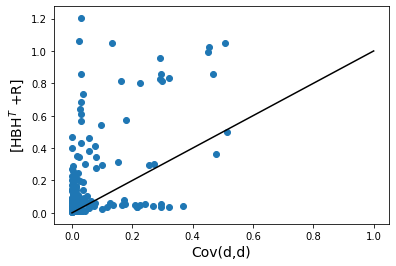

In [71]:
plt.scatter(np.diagonal(diffcov), np.diagonal(K_den2))
plt.plot(np.arange(0,2,1),np.arange(0,2,1),color='k')

plt.xlabel('Cov(d,d)', fontsize=14)
plt.ylabel('[HBH$^T$ +R]', fontsize=14)

In [68]:
ratio = (np.diagonal(diffcov)/np.diagonal(K_den2))

In [31]:
ratio.shape

NameError: name 'ratio' is not defined

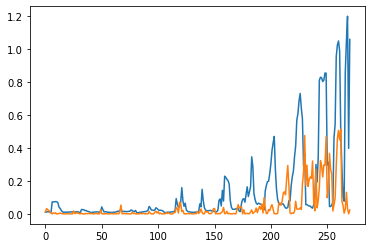

In [69]:
plt.plot(np.diagonal(K_den2))
plt.plot(np.diagonal(diffcov))

In [107]:
HPb3 = np.matmul(H,Pb_initial2/10)
K_den3 = (np.matmul(HPb3,H.T))+R_had

ratio3 = (np.diagonal(diffcov)/np.diagonal(K_den3))

In [108]:
print(str((ratio3>1).sum()/len(ratio3)*100)+'% are > 1')
print(str((ratio3<1).sum()/len(ratio3)*100)+'% are < 1')

47.601476014760145% are > 1
52.398523985239855% are < 1


In [87]:
HPb3 = np.matmul(H,Pb_initial3)
K_den4 = np.matmul(HPb3,H.T)+R_had

ratio4 = (np.diagonal(diffcov)/np.diagonal(K_den4))

In [88]:
print(str((ratio4>1).sum()/len(ratio4)*100)+'% are > 1')
print(str((ratio4<1).sum()/len(ratio4)*100)+'% are < 1')

70.47970479704797% are > 1
29.520295202952028% are < 1


In [70]:
print(str((ratio>1).sum()/len(ratio)*100)+'% are > 1')
print(str((ratio<1).sum()/len(ratio)*100)+'% are < 1')

14.022140221402212% are > 1
85.97785977859779% are < 1


In [26]:
Pb_initial5 = LIMd['C_0']

HPb5 = np.matmul(H,Pb_initial5)
K_den5 = np.matmul(HPb5,H.T)+R_had

ratio5 = (np.diagonal(diffcov)/np.diagonal(K_den5))

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 300 is different from 35424)

In [32]:
ratio4.shape

NameError: name 'ratio4' is not defined

In [ ]:
print(str((ratio5>1).sum()/len(ratio5)*100)+'% are > 1')
print(str((ratio5<1).sum()/len(ratio5)*100)+'% are < 1')

(array([ 0.,  2.,  4.,  6.,  8., 10.]), <a list of 6 Text yticklabel objects>)

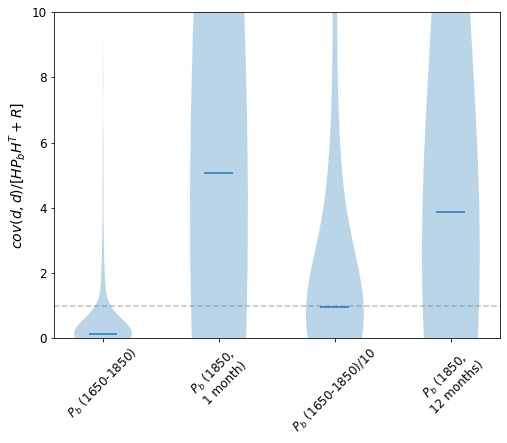

In [106]:
vp_data = [ratio, ratio10, ratio3, ratio4]

fig, ax = plt.subplots(figsize=(8, 6))
plt.axhline(1,linestyle='--', color='gray',zorder=0, alpha=0.5)

vp = ax.violinplot(vp_data,[0,1,2,3],showmeans=False,showmedians=True, showextrema=False)

plt.xticks([0,1,2,3], labels=['$P_b$ (1650-1850)','$P_b$ (1850, \n1 month)','$P_b$ (1650-1850)/10', '$P_b$ (1850, \n12 months)'], 
           fontsize=12, rotation=45)
plt.ylim(0,10)

plt.ylabel('$cov(d,d)/[HP_bH^{T}+R]$', fontsize=14)
plt.yticks(fontsize=12)

### Multiply R by 10: 

In [48]:
HPb = np.matmul(H,Pb_initial)
K_den = np.matmul(HPb,H.T)+(R_had)

(0, 0.3)

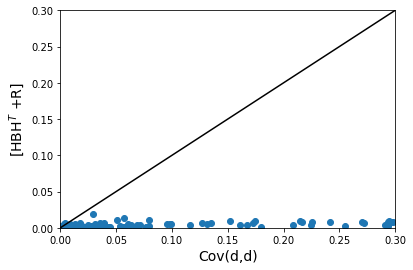

In [49]:
plt.scatter(np.diagonal(diffcov), np.diagonal(K_den))
plt.plot(np.arange(0,2,1),np.arange(0,2,1),color='k')

plt.xlabel('Cov(d,d)', fontsize=14)
plt.ylabel('[HBH$^T$ +R]', fontsize=14)

plt.xlim(0,0.3)
plt.ylim(0,0.3)

In [50]:
ratio10 = (np.diagonal(diffcov)/np.diagonal(K_den))

In [51]:
print(str((ratio10>1).sum()/len(ratio10)*100)+'% are > 1')
print(str((ratio10<1).sum()/len(ratio10)*100)+'% are < 1')

73.80073800738008% are > 1
26.199261992619927% are < 1


### Multipy both R and HBH$^T$ by 10: 

In [263]:
np.sqrt(40)

6.324555320336759

In [370]:
HPb = np.matmul(H,Pb_initial)
#K_den = np.matmul(HPb,H.T)*np.sqrt(40)+R_had*np.sqrt(40)
#K_den = (np.matmul(HPb,H.T)*10+(R_had))*40
K_den = (np.matmul(HPb,H.T)*100+(R_had))*2

Text(0, 0.5, '[HBH$^T$ +R]')

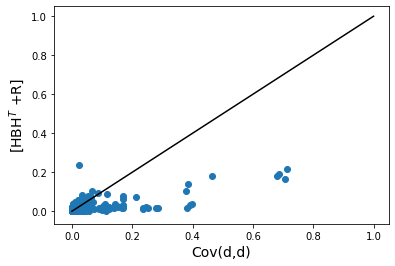

In [371]:
plt.scatter(np.diagonal(diffcov), np.diagonal(K_den))
plt.plot(np.arange(0,2,1),np.arange(0,2,1),color='k')

plt.xlabel('Cov(d,d)', fontsize=14)
plt.ylabel('[HBH$^T$ +R]', fontsize=14)

In [372]:
ratio1010 = (np.diagonal(diffcov)/np.diagonal(K_den))

In [373]:
print(str((ratio1010>1).sum()/len(ratio1010)*100)+'% are > 1')
print(str((ratio1010<1).sum()/len(ratio1010)*100)+'% are < 1')

46.494464944649444% are > 1
53.50553505535055% are < 1


In [369]:
print(str((ratio1010>1).sum()/len(ratio1010)*100)+'% are > 1')
print(str((ratio1010<1).sum()/len(ratio1010)*100)+'% are < 1')

61.62361623616236% are > 1
38.37638376383764% are < 1


### Multiply R by 5: 

In [61]:
HPb = np.matmul(H,Pb_initial)
K_den = np.matmul(HPb,H.T)+(R_had*5)

In [107]:
np.diagonal(R_had*5).max(), np.diagonal(R_had*5).min()

(0.09413130774099893, 0.0003287106684254249)

In [108]:
np.diagonal(np.matmul(HPb,H.T)).max(), np.diagonal(np.matmul(HPb,H.T)).min()

(0.0010924431378751542, 1.0517428120340709e-09)

Text(0, 0.5, '[HBH$^T$ +R]')

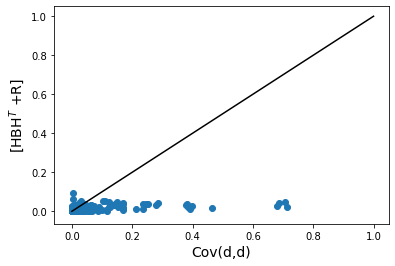

In [62]:
plt.scatter(np.diagonal(diffcov), np.diagonal(K_den))
plt.plot(np.arange(0,2,1),np.arange(0,2,1),color='k')

plt.xlabel('Cov(d,d)', fontsize=14)
plt.ylabel('[HBH$^T$ +R]', fontsize=14)

In [63]:
ratio5 = (np.diagonal(diffcov)/np.diagonal(K_den))

In [64]:
print(str((ratio5>1).sum()/len(ratio5)*100)+'% are > 1')
print(str((ratio5<1).sum()/len(ratio5)*100)+'% are < 1')

52.02952029520295% are > 1
47.97047970479705% are < 1


### Mulitply HBH$^T$ by : 

In [136]:
HPb = np.matmul(H,Pb_initial)
K_den = np.matmul(HPb,H.T)*200+(R_had)

In [137]:
np.diagonal(R_had).max(), np.diagonal(R_had).min()

(0.018826261548199785, 6.574213368508498e-05)

In [138]:
np.diagonal(np.matmul(HPb,H.T)*200).max(), np.diagonal(np.matmul(HPb,H.T)*200).min()

(0.21848862757503085, 2.1034856240681417e-07)

Text(0, 0.5, '[HBH$^T$ +R]')

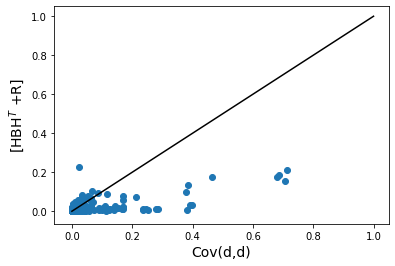

In [139]:
plt.scatter(np.diagonal(diffcov), np.diagonal(K_den))
plt.plot(np.arange(0,2,1),np.arange(0,2,1),color='k')

plt.xlabel('Cov(d,d)', fontsize=14)
plt.ylabel('[HBH$^T$ +R]', fontsize=14)

In [140]:
ratio_10 = (np.diagonal(diffcov)/np.diagonal(K_den))

In [133]:
print(str((ratio_10>1).sum()/len(ratio_10)*100)+'% are > 1')
print(str((ratio_10<1).sum()/len(ratio_10)*100)+'% are < 1')

54.981549815498155% are > 1
45.018450184501845% are < 1


In [141]:
print(str((ratio_10>1).sum()/len(ratio_10)*100)+'% are > 1')
print(str((ratio_10<1).sum()/len(ratio_10)*100)+'% are < 1')

51.291512915129154% are > 1
48.708487084870846% are < 1


In [144]:
diff.shape

(271,)

### Constant R: 

In [92]:
# constant R:
R_test = np.ones((271))*0.1

R_test_cov = np.dot(R_test[:,np.newaxis],R_test[:,np.newaxis].T)

In [100]:
np.diagonal(np.matmul(HPb,H.T)).max()

0.0010924431378751542

In [94]:
np.diagonal(R_test_cov)

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.

In [101]:
HPb = np.matmul(H,Pb_initial)
K_den = np.matmul(HPb,H.T)+(R_test_cov)

Text(0, 0.5, '[HBH$^T$ +R]')

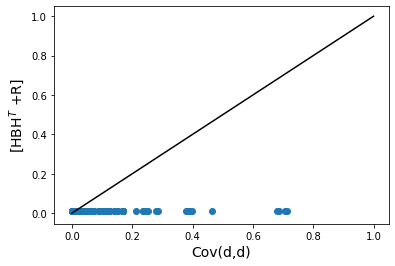

In [102]:
plt.scatter(np.diagonal(diffcov), np.diagonal(K_den))
plt.plot(np.arange(0,2,1),np.arange(0,2,1),color='k')

plt.xlabel('Cov(d,d)', fontsize=14)
plt.ylabel('[HBH$^T$ +R]', fontsize=14)

In [103]:
ratioc = (np.diagonal(diffcov)/np.diagonal(K_den))

In [104]:
print(str((ratioc>1).sum()/len(ratioc)*100)+'% are > 1')
print(str((ratioc<1).sum()/len(ratioc)*100)+'% are < 1')

39.11439114391143% are > 1
60.88560885608856% are < 1


In [42]:
vp_data = [ratio, ratio10, ratio1010, ratio5, ratioc, ratio_10]

fig, ax = plt.subplots()

vp = ax.violinplot(vp_data,[0,1,2,3,4,5],showmeans=False,showmedians=True, showextrema=False)
plt.ylim(0,10)

NameError: name 'ratio10' is not defined

ratio3: times ten both R  
ratio4: nothing, just divide by N for covariances of P and R  
ratio2: times ten both R and HBHT  

(0, 10)

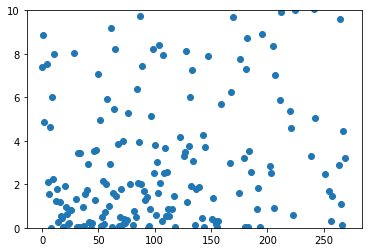

In [146]:
plt.scatter(np.arange(0,271,1),ratio4)
plt.ylim(0,10)

## Kalman Filter t=0: 

There are nans in Xb_initial. Probably worth investigating at some point. Right now, I'm just setting them to zero. 

In [ ]:
# Pb = Pb_initial
# Xb = np.nan_to_num(Xb_initial)
# R = R_had
# Y = HadCRUT_obs_1d 

# # Solve the update equation:
# diff = Y - np.matmul(H,Xb)

# K_num = np.matmul(Pb,H.T)

# HPb = np.matmul(H,Pb_initial)
# #K_den = np.matmul(HPb,H.T)+R_had
# #K_den = np.matmul(np.matmul(H,Pb),H.T)+R
# K_den = (np.matmul(HPb,H.T)+(R_had))
# #K_den = oda.covariance_nans(diff[:,np.newaxis],diff[:,np.newaxis].T, anomalize=False)
# K_den_inv = np.linalg.inv(K_den)
# K = np.matmul(K_num,K_den_inv)

# # Solve the update equation:
# innov = np.matmul(K,diff)

# Xa = Xb + innov

In [27]:
HXb = np.matmul(H,np.nan_to_num(Xb_initial))

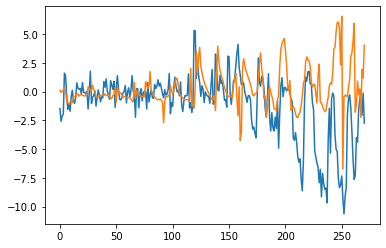

In [28]:
plt.plot(HadCRUT_obs_1d)
plt.plot(HXb)

In [36]:
Xa, K, K_den, diff = oda.solver_KF_update(Xb_initial, a, HadCRUT_obs_1d, R_had, H)

LinAlgError: Singular matrix

In [ ]:
Pa = oda.solver_KF_cov(K,H,Pb)

In [ ]:
diffcov = oda.covariance(diff[:,np.newaxis],diff[:,np.newaxis].T)

In [ ]:
plt.plot(np.diag(diffcov),np.diag(K_den))

In [65]:
np.nan_to_num(Xb_allvars[:,0])

array([-3.38990033e-01, -2.67016053e-01, -3.16474140e-01, ...,
       -1.12167383e-04, -1.12167383e-04, -1.12167383e-04])

In [66]:
Xb_allvars[:,0]

array([-3.38990033e-01, -2.67016053e-01, -3.16474140e-01, ...,
       -1.12167383e-04, -1.12167383e-04, -1.12167383e-04])

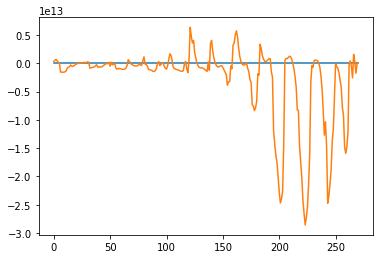

In [172]:
plt.plot(np.matmul(H,Xb_initial))
plt.plot(Had_eofspace_obs)

In [167]:
Projector_tas.shape, H.shape, H_tas.shape

((6912, 50), (271, 300), (271, 50))

In [168]:
Had_eofspace = np.matmul(np.nan_to_num(had_on_refgrid_2d[t,:]),Projector_tas)

Had_eofspace_obs = np.matmul(H_tas,Had_eofspace)

In [169]:
Had_eofspace_obs

array([ 3.46937725e+11,  5.21510364e+11,  6.88038863e+11,  4.33207209e+11,
        1.45869857e+11,  5.33646277e+10, -1.57604121e+12, -1.53521819e+12,
       -1.59936963e+12, -1.58085007e+12, -1.49114137e+12, -1.35681997e+12,
       -8.12110926e+11, -7.23244522e+11, -5.87096809e+11, -3.10154527e+11,
       -5.21836833e+11, -5.55134482e+11, -4.40769145e+11, -2.70879336e+11,
       -1.28075654e+11, -5.36986041e+10, -3.88557507e+10, -1.18787548e+08,
        6.37528028e+10,  1.95046437e+10,  1.07034303e+11,  1.88127538e+11,
        8.21694262e+10,  1.31666810e+11,  2.62004192e+11,  1.86888900e+11,
       -8.73127238e+11, -8.01136394e+11, -7.49993058e+11, -7.06488431e+11,
       -6.55761974e+11, -4.63909170e+11, -2.46378369e+11, -7.07640249e+11,
       -6.20054747e+11, -6.91021181e+11, -6.67527668e+11, -5.78388897e+11,
       -4.13697973e+11, -2.35059316e+11, -9.83415383e+10, -5.40699276e+10,
       -6.59357108e+10,  1.56478809e+11, -5.28712360e+11,  1.87066347e+11,
       -2.61928265e+11, -

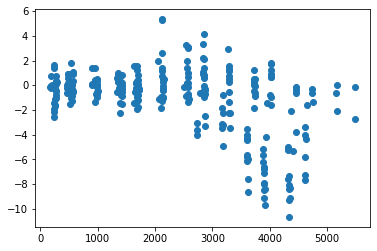

In [151]:
plt.scatter(np.arange(0,6912,1),had_on_refgrid_2d[t,:])

In [128]:
np.nansum(had_on_refgrid_2d[0,:])

-303.73195090187676

In [129]:
had_on_refgrid_2d[0,:]

array([nan, nan, nan, ..., nan, nan, nan])

In [130]:
had_on_refgrid_2d[0,:].shape

(6912,)